Naszym zadaniem jest przeanalizowanie zbioru danych medycznych oraz stworzenia modelu klasyfikującego potencjalnego pacjenta ze względu na fakt wystąpienia udaru mózgu.

Udar mózgu to zespół objawów klinicznych związanych z nagłym wystąpieniem ogniskowego lub uogólnionego zaburzenia czynności mózgu, powstały w wyniku zaburzenia krążenia mózgowego i utrzymującego się ponad 24 godziny.

# Biblioteki

In [ ]:
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate

from yellowbrick import classifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier.rocauc import roc_auc

# Funkcje

In [ ]:
def plotting(data: pd.DataFrame, x: str, type: str, y=None, cl = 'stroke'):
  """
    Function for plotting data in specific way

  Args:
    data - dataset to plot

    x - column for x-axis
    
    y - column for y-axis
    
    type - type of plot 
      values: {'hist', 'box', 'hist_box', 'class_hist', 'class_box', 'class_hist_box', 'scatter', 'heatmap', 'lineplot'} 

    cl - class

  Returns:
    Plot in plotly
  """

  def plot_class_hist():
    """
      Plots histogram with stroke classes in plotly
    """
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==0, x], name='No '+cl))
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==1, x], name=cl))

    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    
    return fig
  
  def plot_class_box():
    """
      Plots boxplot with stroke classes in plotly
    """
    
    fig = go.Figure()
    fig.add_trace(go.Box(y = data.loc[data[cl]==0, x], name='No '+cl))
    fig.add_trace(go.Box(y = data.loc[data[cl]==1, x], name=cl))

    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    
    return fig
    

  if type=='hist':
    fig = px.histogram(data, x=x)
    fig.show()

  elif type=='box':
    fig = px.box(data, x=x)
    fig.show()
  
  elif type=='scatter':
    data['temp'] = data[cl].astype('str')

    fig = px.scatter(data, x=x, y=y, color='temp')
    fig.update_layout(title_text="Scatterplot for " + x)
    fig.update_traces(marker_size=10)
    
    fig.show()
  
  elif type=='heatmap':
    corr = data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

  elif type=='hist_box':
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Histogram(x = data[x], name=x), row=1,col=1)
    fig.add_trace(go.Box(y = data[x], name=x), row=1, col=2)
    
    fig.update_layout(barmode="overlay")
    fig.update_traces(opacity=0.7, row=1, col=1)
    fig.update_layout(title_text="Histogram and Boxplot for " + x)
    fig.show()

  elif type=='class_hist':
    
    fig = plot_class_hist()
    fig.show()
  
  elif type=='class_box':
    
    fig = plot_class_box()
    fig.show()

  elif type=='class_hist_box':
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Histogram(x = data.loc[data[cl]==0, x], name='No '+cl), row=1,col=1)
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==1, x], name=cl), row=1, col=1)
    fig.add_trace(go.Box(y = data.loc[data[cl]==0, x], name='No '+cl), row=1, col=2)
    fig.add_trace(go.Box(y = data.loc[data[cl]==1, x], name=cl), row=1, col=2)

    fig.update_layout(barmode="overlay")
    fig.update_traces(opacity=0.7, row=1, col=1)
    fig.update_layout(title_text="Histogram and Boxplot with classes for " + x)
    fig.show()

  elif type=='lineplot':
    fig = px.line(data, x=x, y=y, color=cl)
    fig.show()

  else:
    raise NotImplementedError('Not implemented!')

  return 0

In [ ]:
def iqr_outliers(df: pd.DataFrame, col: str):
  """
  Function for managin outliers in given column from dataframe using IQR method. 
  In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data. 
  It is defined as the difference between the 75th and 25th percentiles of the data.

  Args:
    df - dataset to remove outliers

    col - column for removing outliers
    
  Returns:
    Whole dataframe with specified column cleaned from outliers using IQR method

  """
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  df.loc[df[col] <= Q1 - 1.5*IQR, col] = df[col].quantile(0.1)
  df.loc[df[col] >= Q3 + 1.5*IQR, col] = df[col].quantile(0.9)

  return df

In [ ]:
def balance_data(X, y, algorithm, cat_features, strategy=1, seed = 123, k_neighbors = 5, n_neighbors=3):
  """
  Function for balancing dataset using specified algorithm and sampling strategy. 

  Args:
    X - matrix of features

    y - vector of target variable observations

    algorithm - algorithm for balancing dataset
      values: {'SMOTE', 'ADASYN', 'SMOTETOMEK', 'SMOTEENN'}

    strategy - sampling information to resample the data set

    Optional **kwargs:
      k_neighbors - number of neighbours for SMOTE algorithm
      n_neighbors - number of neighbours for ADASYN and ENN algorithms

  Returns:
    Whole balanced dataframe 
  """

  ft = []
  for feat in cat_features:
    ft.append(X.columns.get_loc(feat))

  #sm = SMOTE(sampling_strategy = strategy, k_neighbors = k_neighbors)
  sm = SMOTENC(random_state=seed, categorical_features=ft, sampling_strategy = strategy, k_neighbors=k_neighbors)

  if algorithm == 'SMOTE':
    bs = sm

  elif algorithm == 'ADASYN':
    bs = ADASYN(random_state = seed, sampling_strategy = strategy, n_neighbors =n_neighbors)

  elif algorithm == 'SMOTETOMEK':
    
    bs = SMOTETomek(random_state = seed, sampling_strategy = strategy, smote= sm)

  elif algorithm == 'SMOTEENN':
    enn = EditedNearestNeighbours(n_neighbors = n_neighbors)

    bs = SMOTEENN(sampling_strategy = strategy, smote=sm, enn = enn)
  
  else:
    raise NotImplementedError('Not implemented!')

  X_bs,  y_bs = bs.fit_resample(X, y)

  df_bs = X_bs.copy()
  df_bs['stroke'] = y_bs

  X_bs = X_bs.drop(columns='index', axis=1)

  print("Liczba wszystkich obserwacji: ", len(y_bs))
  print("\nLiczba obserwacji z klasy mniejszościowej: ", len(y_bs[y_bs==1]))
  print("\nProcent klasy mniejszościowej do całości po zbalansowaniu: ", len(y_bs[y_bs == 1])/len(y_bs))
  
  return df_bs, X_bs, y_bs

In [ ]:
#Stwórz klase z doborem parametru thresholda p

class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

In [ ]:
def fit_pred_score(X_train, y_train, X_test, y_test, model, model_name, dataset_name, scaler=True, ohe = False, columns_to_standardize = None, cat_features = None, visualize_train = True, visualize_test = True, show_coefficients = False, threshold = None):
  """
  Function for training and testing given classifier. 
  It plots classification reports for train and test data and might display coefficients of predictors. 
  Returns report in dataframe format for given model and dataset with metrics from classification report.

  Args:

    X_train, y_train, X_test, y_test - training and testing data with associated labels

    model - model to train and test

    model_name - name of the model for the report

    dataset_name - dataset name used for the report

    scaler - if features should be scaled

    columns_to_standardize - columns which should be scaled if scaler = True

    visualize_train - if classification report for training data should be visualized

    visualize_test - if classification report for testing data should be visualized

    show_coefficients - if coefficients of features should be displayed

    threshold - value of 'p' for Logistic Regression model

  Returns:

    report - dataframe with metrics from classification report with associated dataset and model name
  """

  def ohe(df: pd.DataFrame, cat_features):
    df_ohe = df[cat_features].astype('str')
    dummies = pd.get_dummies(df_ohe)

    df = df.drop(columns=cat_features, axis=1)
    df = pd.merge(df, dummies, left_index=True, right_index=True)
    
    return df
  
  X = X_train.copy()
  X_t = X_test.copy()

  if scaler == True:
    sc = preprocessing.StandardScaler()
    X[columns_to_standardize] = sc.fit_transform(X_train[columns_to_standardize])
    X_t[columns_to_standardize] = sc.transform(X_t[columns_to_standardize])

  if ohe ==True:
    X = ohe(X, cat_features)
    X_t = ohe(X_t, cat_features)

  model.fit(X, y_train)

  if threshold == None:
    y_pred = model.predict(X_t)
  else:
    y_pred = model.predict(X_t, threshold = threshold)

  classes=['No stroke', 'Stroke']

  #plot classification report for training data
  if visualize_train == True:
    visualizer = ClassificationReport(
          model, classes=classes)
    visualizer.fit(X, y_train)
    visualizer.score(X, y_train)
    visualizer.show()

  if visualize_test == True:
    #plot classification report for test data
    classifier.classification_report(model, X, y_train, X_t, y_test, classes=classes)

  if show_coefficients == True:
    coef_dict = {}
    for coef, feat in zip(model.coef_[0,:],X.columns):
      print(feat, " = ", coef)

  report = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names = classes, output_dict=True))
  report['metric'] = report.index
  report.reset_index(inplace=True, drop=True)
  report['dataset_name'] = dataset_name
  report['model_name'] = model_name
  
  return report

In [71]:
def transform_report_to_plot(dt : pd.DataFrame, x : str):
  """
  Function transforms report dataset for plotting in a way that for F1-score macro avg value is taken, for precision the values for no stroke and for recall the values for stroke. 
  
  Args:
    dt - filtered dataset

    x - axis

  Returns:
    df - transformed report dataframe
  """

  #cols_to_select
  f1_s = dt.loc[(dt.metric == 'f1-score'),['macro avg','metric', x]]
  precision_s = dt.loc[(report.metric == 'precision'),['Stroke','metric', x]]
  precision_s.metric = "Precision (Stroke)"
  recall_s = dt.loc[(dt.metric == 'recall'),['Stroke','metric', x]]
  recall_s.metric = "Recall (Stroke)"
  precision_ns = dt.loc[(report.metric == 'precision'),['No stroke','metric', x]]
  precision_ns.metric = "Precision (No stroke)"
  recall_ns = dt.loc[(dt.metric == 'recall'),['No stroke','metric', x]]
  recall_ns.metric = "Recall (No stroke)"

  columns = ['value', 'metric', '']
  for d in [f1_s, precision_s, recall_s, precision_ns, recall_ns]:
    d.columns = columns

  df = pd.concat([f1_s, precision_s, recall_s, precision_ns, recall_ns])
  return df

# Dane

In [ ]:
url = 'https://github.com/maju116/Statistics_II_GUT/raw/main/PROJECT/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(url)

df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Mamy łącznie 12 kolumn po 5110 obserwacji z czego jedna z nich stanowi ('stroke') zmienną celu i będziemy starać się ja zamodelować. Jest to zmienna binarna informująca czy dany pacjent miał udar mózgu czy też nie zatem jest to typowe zadanie klasyfikujące. Oprócz tego jest pozostałych 11 zmiennych:
- zmienna **id** typu integer przypisująca konkretnego pacjenta nie wnosi raczej żadnej wartości informacyjnej ale pozwoli nam sprawdzić czy jakiś pacjent jest dwukrotnie w historii co mogłoby wskazywać na podwyższone ryzyko udaru.
- zmienna **gender** typu object jest zmienną binarną wskazująca na płeć pacjenta, z pewnością będzie trzeba ją zakodować. Spodziewa się, iż będzie dawała istotną informacje dla zmiennej celu. 
- zmienna **age** typu float jest zmienną numeryczną wskazująca na wiek pacjenta i także można się spodziewać że będzie istotna w modelowaniu. Mamy tutaj zakres wartości od 25 do 82 bez raczej mocnych ogonów.
- zmienna **hypertension** typu integer jest zmienną binarną informująca o nadciśnieniu pacjenta.
- zmienna **heart_disease** typu integer jest zmienną binarną informująca o występowaniu chorób serca.
- zmienna **ever_married** typu object jest zmienną kategoryczną informująca o tym czy pacjent kiedykolwiek był w związku małżeńskim.
- zmienna **work_type** typu object jest zmienną kategoryczną informująca o typie zatrudnieniu.
- zmienna **residence_type** typu object jest zmienną kategoryczną informująca o strukturze miejsca zamieszkania.
- zmienna **avg_glucose_level** typu float jest zmienną numeryczną informująca o przeciętnyn poziomie glukozy we krwi.
- zmienna **bmi** typu float jest zmienną numeryczną informująca o wskaźniku BMI pacjenta. Posiada 201 braków danych.
- zmienna **smoking_status** typu object jest zmienną kategoryczną informująca o tym czy i jak często palił pacjent.
- zmienna **stroke** typu int jest zmienną binarną informująca czy pacjent doznał udaru mózgu i jest to nasza zmienną celu.

Widzimy, że mamy 211 braków danych dla zmiennej **bmi**, którymi zajmiemy się w dalszej części projektu.

# EDA

### stroke

In [ ]:
df.stroke.value_counts()

In [ ]:
plotting(df, 'stroke', type = 'hist')

Widzimy, że nasza zmienna celu jest niezbalansowana gdzie klasą większościową są pacjenci bez udaru mózgu. Musimy mieć to na uwadze i w przypadku pozostawienia takiego stanu rzeczy nie możemy skorzystać z metryki **accuracy**, a powinniśmy skorzystać z innej - przykładowo średniej harmonicznej między **precision** a **recall** czyli **f1-score**. Niezbalansowany zbiór danych jest jednak dość problemtyczny, gdyż klasyfikator ma tendencję skupiania się na predykcji klasy większościowej. 

Istnieją sposoby na zbalansowanie zbioru danych, które są częścią **pre-processingu** czyli wstępnego przetwarzania danych przed modelowaniem. Do jednych z bardziej popularnych metod należą:
- **undersampling** - pozostawia wszystkie obserwacje z klasy mniejszościowej i losowo eliminuje obiekty z klasy większościowej
- **oversampling** - pozostawia wszystkie obserwacje z klasy większościowej i losowo replikuje elementy z klasy mniejszościowej

W przypadku undersamplingu możemy pozbyć się istotnych informacyjnie obserwacji. Dodatkowo nasz zbiór danych jest niewielki, więc nie chcielibyśmy się ograniczyć do zaledwie 249 obserwacji. Natomiast oversampling może doprowadzić do nadmiernego dopasowania modelu do naszych danych. Istnieje też podejście mieszane wykorzystujące zarówno undersampling, jak też oversampling ale ciężko jest ustalić optymalną proporcję między podejściami. Spróbujemy sprawdzić empirycznie najlepszą metodę i się do niej ograniczyć oczywiście opierając się nie o zwykłe próbkowanie, a dostępne i znane algorytmu balansowania zbiorów danych.

### id

In [ ]:
print("Liczba zduplikowanych wartości ID pacjentów: ", len(df[df.id.duplicated()]))

W naszym zbiorze danych każdy pacjent jest wpisany unikalnie, tak więc zmienna ID raczej do niczego więcej nam się nie przyda i będziemy mogli ją pozostawić w dalszych etapach. 

### gender

In [ ]:
plotting(data = df, x='gender',  type='class_hist')

In [ ]:
df.gender.value_counts()

W zmiennej gender występują 3 wartości (male, female, other). Wartość 'Other' występuje tylko jeden raz, więc można go potraktować jako brak danych. W zależności od wartości pozostałych zmiennej dla tej obserwacji albo zastąpimy ją wartością male lub female (jako tą która najczęściej występuje) albo usuniemy.

### age

In [ ]:
plotting(data = df, x='age',  type='hist_box')

In [ ]:
plotting(data = df, x='age',  type='class_hist_box')

Możemy zaobserwować, że udar mózgu w naszym zbiorze mają głównie osoby w podeszłym wieku (60-80 lat). Natomiast osoby bez udaru rozkładają się dość równomiernie, mediana wynosi 43 lata, gdzie dla osób z udarem 71 lat. Dodatkowo występują zmienne odstające w grupie ludzi z udarem. Sam rozkład zmiennej zbliżony jest do rozkładu jednostajnego. 

### hypertension

In [ ]:
plotting(data = df, x='hypertension',  type='class_hist')

Można zauważyć, że znaczna większość pacjentów nie ma nadciśnienia. Co więcej, mimo braku zbalansowanego zbioru danych, więcej pacjentów z udarem mózgu nie miało przy tym nadciśnienia. 

### heart_disease

In [ ]:
plotting(data = df, x='heart_disaease',  type='class_hist')

Podobna sytuacja jak dla zmiennej hypertension. Znaczna większość pacjentow nie ma chorób serca oraz mimo braku zbalansowania, większość osób z udarem także nie ma chorób serca. 

### ever_married

In [ ]:
plotting(data = df, x='ever_married',  type='class_hist')

Zmienna ever_married jest zmienną kategoryczną, którą będzie trzeba zakodować w wartości (0,1). Większa część pacjentów była kiedykolwiek żonata oraz to w tej grupie udar mózgu występuje w większej ilości. 

### work_type

In [ ]:
plotting(data = df, x='work_type',  type='class_hist')

Zmienna work_type określająca rodzaj wykonywanej pracy jest także zmienną kategoryczną, którą zakodujemy w wartości numeryczne. Najwięcej pacjentów jest z kategorii 'private', następnie równiemiernie ilościowo rozłożeni między 'children', 'self_employed', 'govt_job'. Znikoma ilość nigdy nie pracowała. Największa ilość udarów znajduje się wśród sektora prywatnego oraz samo-zatrunionego. Niewielka część w sektorze publicznym. Pojedyncze wartości występują też w grupie dzieci, ale z poprzednich wniosków najprawdopodobniej są to obserwacje odstające. Można także spróbować zkoszykować tą zmienną i rozdzielić na sektor obciążony i nieobciążony względem ryzyka udaru mózgu. 

### residence_type

In [ ]:
plotting(data = df, x='Residence_type',  type='class_hist')

Zmienna określa obszar zamieszkania z rozdziałem na wiejski i miejski. Widać, że podział jest równomierny oraz w każdym z podziałów jest zbliżona proporcja osób po udarze do osób bez udaru mózgu, więc zmienna ta niesie ze sobą najpewniej niewielką ilość informacji dla potencjalnego modelu. 

### avg_glucose_level

In [ ]:
plotting(data = df, x='avg_glucose_level',  type='hist_box')

In [ ]:
plotting(data = df, x='avg_glucose_level',  type='class_hist_box')

Możemy zaobserwować, że najwięcej jest pacjentów ze średnim poziomem glukozy w przedziale 77.24 - I kwantyl, 114.09 - II kwantyl, a więc z poziomem prawidłowym lub stanem przedcukrzycowym. Wniosek ten jednak jest uogólniony, gdyż zakres ten jest nieco inny w zależności od pory czy też sposobu wykonywanego badania, a także wieku badanej osoby. Osoby z wyższym średnim poziomem glukozy we krwi są outlierami dla grupy bez udaru mózgu, natomiast dla pozostałej części osób mieszczą się one w IV kwantylu. Więc usunięcie tych obserwacji, lub też zmiana ich wartości spowodowałaby utratę być może znaczącej informacji. Zamiast tego spróbujemy wykorzystać tą zależność tworząc nową zmienną kategoryczną informującą o średnim zakresie glukozy (poziom prawidłowy, stan przedcukrzycowy, cukrzyca) oraz imputując nowe wartości, jak też transformując całą zmienną. 


### bmi

In [ ]:
plotting(data = df, x='bmi',  type='hist_box')

In [ ]:
plotting(data = df, x='bmi',  type='class_hist_box')

Rozkład zmiennej bmi przypomina rozkład normalny z cięższym prawym ogonem. Występują też outliery dla bmi > 47.5. Większość pacjentów zawiera się w przedziale 23.5 - 33.1 czyli jest z wagą prawidłową lub nadwagą I stopnia. O ile sama zmienna może nie nieść zbyt dużej informacji z uwagi, że rozkład wartości jest zbliżony dla osób z udarem, jak i bez udaru to niemniej możliwe są pewne istotne interakcje między pozostałymi zmiennymi jak chociażby średnim poziomem glukozy we krwi. W kontekście danych odstających również można stworzyć zmienną kategoryczną zgodnie z kategoriami wskaźników BMI.

Dodatkowo zmienna BMI zawiera braki danych, którymi należy się zająć. Istnieje na to wiele metod m.in. 
- usunięcie obserwacji
- wypełnienie ich statystyką opisową typu średnia, mediana
- wykorzystanie algorytmów ML takich jak KNN

Z racji, iż braków danych jest niewiele (zaledwie 4%) to wypełnimi ich statystyką opisową jako działaniem prostym, ale i skutecznym. Jak wspomniano, rozkład zmiennej jest zbliżony do normalnego więc nie ma większego znaczenia wybór między medianą, a średnią ale zważywszy na lekki ogon prawostronny wybrana zostanie mediana. Dla obserwacji odstających posłużymy się metodą IQR.

### smoking_status

In [ ]:
plotting(data = df, x='smoking_status',  type='class_hist_box')

Ciężko wyciągnać tu szersze wnioski zważywszy na dość liczną grupę 'Unknown', Najliczniejsza grupa pacjentów nigdy nie paliła papierosów zakładając, że w grupie 'Unknown' wartości rozkładałyby się w miare równomiernie. Widać rozróżnienei dla osób z udarem, że w większości są to osoby niepalące lub palące sporadycznie. Sprawdźmy wiek osób dla grupy Unknown, być może w naturalny sposób wydzieli nam się grupa osób niepełnoletnich.

In [ ]:
plotting(data=df[(df.age <= 16)], x='smoking_status', type='class_hist')

Widzimy, że dla osób niepełnoletnich wartość smoking_status jest w większości równa 'Unknown'. Należy coś z tą grupą osób zrobić, jednakże nie można po prostu usunąć tych obserwacji, gdyż udar mózgu dotyczyć może także dzieci. Z jednej strony można zaklasyfikować te osoby do grupy 'Never smoked', jednak jest wysoce prawdopodobne, że w rzeczywistości część osób może 'popalać'. Stworzymy więc nową kategorię 'Underage' dla tych pacjentów. 

# Inżynieria cech

W inżynierii cech będziemy tworzyli nowe zmienne z już istniejących, zajmowali się brakiem danych czy też odstającymi obserwacjami. Do tego ostatniego skorzystamy z metody rozstępu międzyćwiartylkowego IQR. Jest to różnica między trzecim a pierwszym kwartylem. Ponieważ pomiędzy tymi kwartylami znajduje się z definicji 50% wszystkich obserwacji (położonych centralnie w rozkładzie), dlatego im większa szerokość rozstępu ćwiartkowego, tym większe zróżnicowanie cechy. Dodatkowo na końcu dokonamy balansowania naszego zbioru z wykorzystaniem 4 technik: SMOTE, ADASYN, SMOTE+Tomek, SMOTE ENN. 

In [ ]:
#głęboka kopia danych

df_clear = df.copy()

### bmi

- imputacja braków danych przy użyciu mediany
- stworzenie nowej zmiennej kategorycznej na podstawie istniejącej zmiennej numerycznej oraz zakodowanie jej. Do kategoryzacji posłużymy się kategoriami zaproponowanymi przez 'Centers for Disease Control and Prevention' (https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html).
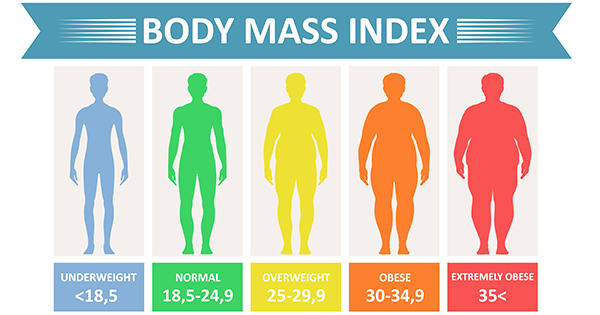
- dodanie zmiennej numerycznej bez danych odstających poprzez wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl
- log-transformacja zmiennej oraz wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl

In [ ]:
#imputacja mediany w miejsca NA
df_clear['bmi_no_nan'] = df_clear.bmi.fillna(df_clear.bmi.median())

#zmienna numeryczna bez outlierów
df_clear['bmi_no_outliers'] = df_clear.bmi_no_nan
df_clear = iqr_outliers(df_clear, 'bmi_no_outliers')

#log-transformacja bez outlierów
df_clear['log_bmi_no_outliers'] = np.log(df_clear.bmi_no_nan)
df_clear = iqr_outliers(df_clear, 'log_bmi_no_outliers')
df_clear.info()

#nowa zmienna kategoryczna zgodnie ze wskaźnikami BMI
df_clear.loc[(df_clear.bmi_no_outliers < 18.5), 'bmi_categorical'] = 'underweight'
df_clear.loc[(df_clear.bmi_no_outliers >= 18.5) & (df_clear.bmi_no_outliers < 24.9), 'bmi_categorical'] = 'normal'
df_clear.loc[(df_clear.bmi_no_outliers >= 24.9) & (df_clear.bmi_no_outliers < 29.9), 'bmi_categorical'] = 'overweight'
df_clear.loc[(df_clear.bmi_no_outliers >= 29.9) & (df_clear.bmi_no_outliers < 34.9), 'bmi_categorical'] = 'obese'
df_clear.loc[(df_clear.bmi_no_outliers >= 34.9), 'bmi_categorical'] = 'extremely obese'

#kodowanie medianą przedziałów
df_clear.loc[df_clear.bmi_categorical == 'underweight', 'bmi_categorical_encoded'] = int(df_clear.loc[df_clear.bmi_categorical == 'underweight','bmi_no_outliers'].median())
df_clear.loc[df_clear.bmi_categorical == 'normal', 'bmi_categorical_encoded'] = int(df_clear.loc[df_clear.bmi_categorical == 'normal','bmi_no_outliers'].median())
df_clear.loc[df_clear.bmi_categorical == 'overweight', 'bmi_categorical_encoded'] = int(df_clear.loc[df_clear.bmi_categorical == 'overweight','bmi_no_outliers'].median())
df_clear.loc[df_clear.bmi_categorical == 'obese', 'bmi_categorical_encoded'] = int(df_clear.loc[df_clear.bmi_categorical == 'obese','bmi_no_outliers'].median())
df_clear.loc[df_clear.bmi_categorical == 'extremely obese', 'bmi_categorical_encoded'] = int(df_clear.loc[df_clear.bmi_categorical == 'extremely obese','bmi_no_outliers'].median())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5110 non-null   int64  
 1   gender               5110 non-null   object 
 2   age                  5110 non-null   float64
 3   hypertension         5110 non-null   int64  
 4   heart_disease        5110 non-null   int64  
 5   ever_married         5110 non-null   object 
 6   work_type            5110 non-null   object 
 7   Residence_type       5110 non-null   object 
 8   avg_glucose_level    5110 non-null   float64
 9   bmi                  4909 non-null   float64
 10  smoking_status       5110 non-null   object 
 11  stroke               5110 non-null   int64  
 12  bmi_no_nan           5110 non-null   float64
 13  bmi_no_outliers      5110 non-null   float64
 14  log_bmi_no_outliers  5110 non-null   float64
dtypes: float64(6), int64(4), object(5)
mem

In [ ]:
for col, types in zip(['bmi_no_nan', 'bmi_categorical', 'bmi_no_outliers', 'log_bmi_no_outliers'], ['class_hist_box','class_hist','class_hist_box','class_hist_box']):
  plotting(data = df_clear, x=col, type=types)

Możemy zaobserwować, że wypełnienie braków danych spowodowało peak w punkcie mediany co jest naturalnym efektem zastosowanej metody. 

Dodatkowo, najbardziej liczna jest grupa osób z nadwagą i to tam również najliczniej występują osoby z udarem mózgu. W przypadku usunięcia outlierów mozemy zaobserwować pozbycie się ogona prawostronnego, natomiast zastosowanie log-transformacji wydaje się nie mieć znacznego wpływu poza przeskalowaniem co będzie zbędne z racji iż w późniejszym etapie będziemy dokonywać standaryzacji zmiennych, dlatego odrzucimy tą zmienną. 

Co więcej, możemy zauważyć, że przypisanie granicznych wartości kwantylowych nie zlikwidowało danych odstających w grupie osób z udarem. W tej sytuacji możemy usunąć obserwacje specjalnie dla tej grupy, ale nie są to pojedyncze przypadki a i tak jest ona mało liczna. W takim razie, z racji dalszego lekkiego zaszumienia zmiennej przez te obserwacje, pozostaniemy przy zmiennej kategorycznej koszykującej do odpowiedniej grupy. Jest to dość powszechne rozwiązanie dla BMI, gdyż to powszechny indeks wagi ciała.  

### gender
- z racji, iż jest to tylko jedna obserwacja i ciężko jest ją odpowiednio podmienić (pozostałe zmienne są mocno rozrzucone, więc nie niosą wystarczającej informacji do imputacji) zostanie usunięta
- kodowanie zmiennej

In [ ]:
df_clear = df_clear.loc[df_clear.gender != 'Other',:]
df_clear.loc[df_clear.gender == 'Female', 'is_female'] = 1
df_clear.loc[df_clear.gender == 'Male', 'is_female'] = 0
df_clear.is_female = df_clear.is_female.astype('int')

df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5109 non-null   int64  
 1   gender                   5109 non-null   object 
 2   age                      5109 non-null   float64
 3   hypertension             5109 non-null   int64  
 4   heart_disease            5109 non-null   int64  
 5   ever_married             5109 non-null   object 
 6   work_type                5109 non-null   object 
 7   Residence_type           5109 non-null   object 
 8   avg_glucose_level        5109 non-null   float64
 9   bmi                      4908 non-null   float64
 10  smoking_status           5109 non-null   object 
 11  stroke                   5109 non-null   int64  
 12  bmi_no_nan               5109 non-null   float64
 13  bmi_no_outliers          5109 non-null   float64
 14  log_bmi_no_outliers     

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

### age
- pozbycie się outlierów dla klasy 'stroke', gdyż widać zróżnicowanie dla tej grupy i pozostawienie ich mogłoby wprowadzić zbędny szum

In [ ]:
#tablica z pacjentami z udarem
df_stroke = df_clear[df_clear.stroke == 1].copy()
#pozbycie sie outlierow
df_stroke = iqr_outliers(df=df_stroke, col='age')
#ponowna konkatenacja zbioru
df_clear = pd.concat([df_clear[df_clear.stroke==0], df_stroke])
#plot
plotting(data=df_clear, x='age', type='class_hist_box')
#podsumowanie
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5109 non-null   int64  
 1   gender                   5109 non-null   object 
 2   age                      5109 non-null   float64
 3   hypertension             5109 non-null   int64  
 4   heart_disease            5109 non-null   int64  
 5   ever_married             5109 non-null   object 
 6   work_type                5109 non-null   object 
 7   Residence_type           5109 non-null   object 
 8   avg_glucose_level        5109 non-null   float64
 9   bmi                      4908 non-null   float64
 10  smoking_status           5109 non-null   object 
 11  stroke                   5109 non-null   int64  
 12  bmi_no_nan               5109 non-null   float64
 13  bmi_no_outliers          5109 non-null   float64
 14  log_bmi_no_outliers    

### ever_married
- zakodowanie zmiennej

In [ ]:
df_clear.loc[df_clear.ever_married == 'Yes', 'is_married'] = 1
df_clear.loc[df_clear.ever_married == 'No', 'is_married'] = 0
df_clear.is_married = df_clear.is_married.astype('int')

df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5109 non-null   int64  
 1   gender                   5109 non-null   object 
 2   age                      5109 non-null   float64
 3   hypertension             5109 non-null   int64  
 4   heart_disease            5109 non-null   int64  
 5   ever_married             5109 non-null   object 
 6   work_type                5109 non-null   object 
 7   Residence_type           5109 non-null   object 
 8   avg_glucose_level        5109 non-null   float64
 9   bmi                      4908 non-null   float64
 10  smoking_status           5109 non-null   object 
 11  stroke                   5109 non-null   int64  
 12  bmi_no_nan               5109 non-null   float64
 13  bmi_no_outliers          5109 non-null   float64
 14  log_bmi_no_outliers    

### work_type
- zakodowanie zmiennej

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_clear.work_type)
df_clear['work_type_encoded'] = le.transform(df_clear.work_type)
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5109 non-null   int64  
 1   gender                   5109 non-null   object 
 2   age                      5109 non-null   float64
 3   hypertension             5109 non-null   int64  
 4   heart_disease            5109 non-null   int64  
 5   ever_married             5109 non-null   object 
 6   work_type                5109 non-null   object 
 7   Residence_type           5109 non-null   object 
 8   avg_glucose_level        5109 non-null   float64
 9   bmi                      4908 non-null   float64
 10  smoking_status           5109 non-null   object 
 11  stroke                   5109 non-null   int64  
 12  bmi_no_nan               5109 non-null   float64
 13  bmi_no_outliers          5109 non-null   float64
 14  log_bmi_no_outliers    

### Residence_type
- zakodowanie zmiennej

In [ ]:
df_clear.loc[df_clear.Residence_type == 'Rural', 'is_rural'] = 1
df_clear.loc[df_clear.Residence_type == 'Urban', 'is_rural'] = 0 
df_clear.is_rural = df_clear.is_rural.astype('int')

df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5109 non-null   int64  
 1   gender                   5109 non-null   object 
 2   age                      5109 non-null   float64
 3   hypertension             5109 non-null   int64  
 4   heart_disease            5109 non-null   int64  
 5   ever_married             5109 non-null   object 
 6   work_type                5109 non-null   object 
 7   Residence_type           5109 non-null   object 
 8   avg_glucose_level        5109 non-null   float64
 9   bmi                      4908 non-null   float64
 10  smoking_status           5109 non-null   object 
 11  stroke                   5109 non-null   int64  
 12  bmi_no_nan               5109 non-null   float64
 13  bmi_no_outliers          5109 non-null   float64
 14  log_bmi_no_outliers    

### avg_glucose_level
- stworzenie nowej zmiennej kategorycznej na podstawie istniejącej zmiennej numerycznej oraz zakodowanie jej
- dodanie zmiennej numerycznej bez danych odstających poprzez wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl
- log-transformacja zmiennej oraz wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl

In [ ]:
#nowa zmienna kategoryczna zgodnie ze wskaźnikami BMI
df_clear.loc[(df_clear.avg_glucose_level < 140), 'glucose_categorical'] = 'normal'
df_clear.loc[(df_clear.avg_glucose_level >= 140) & (df_clear.avg_glucose_level <= 199), 'glucose_categorical'] = 'prediabetes'
df_clear.loc[(df_clear.avg_glucose_level > 199), 'glucose_categorical'] = 'diabetes'

#kodowanie
le_gl = preprocessing.LabelEncoder()
le_gl.fit(df_clear.glucose_categorical)
df_clear['glucose_categorical_encoded'] = le_gl.transform(df_clear.glucose_categorical)
df_clear.info()

#zmienna numeryczna bez outlierów
df_clear['glucose_no_outliers'] = df_clear.avg_glucose_level
df_clear = iqr_outliers(df_clear, 'glucose_no_outliers')

#log-transformacja bez outlierów
df_clear['log_glucose_no_outliers'] = np.log(df_clear.avg_glucose_level)
df_clear = iqr_outliers(df_clear, 'log_glucose_no_outliers')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5109 non-null   int64  
 1   gender                       5109 non-null   object 
 2   age                          5109 non-null   float64
 3   hypertension                 5109 non-null   int64  
 4   heart_disease                5109 non-null   int64  
 5   ever_married                 5109 non-null   object 
 6   work_type                    5109 non-null   object 
 7   Residence_type               5109 non-null   object 
 8   avg_glucose_level            5109 non-null   float64
 9   bmi                          4908 non-null   float64
 10  smoking_status               5109 non-null   object 
 11  stroke                       5109 non-null   int64  
 12  bmi_no_nan                   5109 non-null   float64
 13  bmi_no_outliers  

In [ ]:
for col, types in zip(['glucose_categorical', 'glucose_no_outliers', 'log_glucose_no_outliers'], ['class_hist','class_hist_box','class_hist_box']):
  plotting(data = df_clear, x=col, type=types)

Najbardziej liczna jest grupa osób z prawidłowym kategorią średniego poziomu glukozy we krwi i to tam również najliczniej występują osoby z udarem mózgu (zaliczono tam także I stopień otyłości). 

W kontekście kategoryzacji zmiennej otrzymano raczej spadek informacji, gdyż została jedna najliczniejsza grupa osób z udarem oraz pozostałe z podobną licznością. Co więcej, jak wspomniano, ciężko jednoznacznie wpisać w kategorie gdyż nie znamy właściwości pomiaru cukru, jak też dodatkowych chorób pacjentów takich jak cukrzyca. 

Widzimy także, że metoda IQR z imputacją zamiast usunięcia danych dalej zachowała pewne dane odstające. Jednakże przy skorzystaniu z log-transformacji, są to nieliczne wartości mocno zbliżone do wartości górnej. Mając to na uwadze, jak też fakt spadku informacji po kategoryzacji ograniczymy się do tej zmiennej. 

### smoking_status
- stworzenie nowej grupy 'Underage' dla osób niepełnoletnich
- zakodowanie zmiennej

In [ ]:
df_clear['smoking_status_new'] = df_clear.smoking_status
df_clear.loc[df_clear.age <= 18, 'smoking_status_new'] = 'underage'
print("Grupa 'Unknown' stanowi %.2f procent obserwacji całościowego zbioru" % (len(df_clear[df_clear.smoking_status_new == 'underage'])/len(df_clear)))
plotting(data=df_clear, x='smoking_status_new', type='class_hist')

Grupa 'Unknown' stanowi 0.18 procent obserwacji całościowego zbioru


0

W dalszym ciągu grupa Unknown jest dość liczna, ale wydobyliśmy za to bardziej zróżnicowany podział i pozostawimy to w ten sposób. 

In [ ]:
le_ss = preprocessing.LabelEncoder()
le_ss.fit(df_clear.smoking_status_new)
df_clear['smoking_status_encoded'] = le_ss.transform(df_clear.smoking_status_new)
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5109 non-null   int64  
 1   gender                       5109 non-null   object 
 2   age                          5109 non-null   float64
 3   hypertension                 5109 non-null   int64  
 4   heart_disease                5109 non-null   int64  
 5   ever_married                 5109 non-null   object 
 6   work_type                    5109 non-null   object 
 7   Residence_type               5109 non-null   object 
 8   avg_glucose_level            5109 non-null   float64
 9   bmi                          4908 non-null   float64
 10  smoking_status               5109 non-null   object 
 11  stroke                       5109 non-null   int64  
 12  bmi_no_nan                   5109 non-null   float64
 13  bmi_no_outliers  

### Analiza korelacji

In [ ]:
plotting(data=df_clear.loc[:,~df_clear.columns.isin(['id'])], x='none', type='heatmap')

Widoczna jest słaba korelacja między zmiennymi oraz między zmiennymi, a zmienną celu. Największe wartości widoczne są przy tych samych zmiennych, ale po przeprowadzeniu transformacji lub kodowania co jest rezultatem oczywistym. Jedyne zmienne, które są skorelowane na jakimś możliwie znaczącym poziomie to zmienna 'age', 'work_type', 'smoking_status', 'bmi', 'is_married' jednak wartości te w ogólności nie są zbyt wysokie i nie występuje tutaj problem współliniowości. Ciężko także na tej podstawie dokonać selekcji zmiennych, więc raczej skorzystamy w późniejszym etapie z regularyzacji LASSO.

### Polynomial features 

Bardzo często wejściowe zmienne są interaktywne ze sobą w sposób nieliniowy. Takie interkacje mogą zostać później wykryte i wykorzystane przez model przy etapie selekcji zmiennych. Co więcej, podniesienie niektórych zmiennych do pewnej potęgi może pomóc w wyodrębnieniu istotnych relacji między tą zmienną, a zmienną celu. Przeważnie wystarczy podniesienie do stopnia drugiego (ewentualnie trzeciego), gdyż wielomiany stopnia czwartego i wyższego są nadmiernie elastyczne, mają nieregularne kształty i mogą prowadzić do overfittingu. My wykorzystamy cechy wielomianowe stopnia drugiego. 

In [ ]:
#get PolynomialFeatures transfomer
poly = preprocessing.PolynomialFeatures(2)

#select only apriori chosen variables
X_poly = df_clear.select_dtypes(['int','float'])
X_poly = X_poly.loc[:,~X_poly.columns.isin(['id', 'bmi_no_nan','bmi','avg_glucose_level','glucose_no_outliers', 'log_bmi_no_outliers', 'bmi_no_outliers','glucose_categorical_encoded'])]
print("Ramka wejściowa")
X_poly.info()

print("\nRamka wyjściowa po PolyFeatures transformacji")
df_poly = pd.DataFrame(poly.fit_transform(X_poly), columns = poly.get_feature_names_out(X_poly.columns))
df_poly.info()

Ramka wejściowa
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 249 to 248
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      5109 non-null   float64
 1   hypertension             5109 non-null   int64  
 2   heart_disease            5109 non-null   int64  
 3   stroke                   5109 non-null   int64  
 4   bmi_categorical_encoded  5109 non-null   float64
 5   is_female                5109 non-null   int64  
 6   is_married               5109 non-null   int64  
 7   work_type_encoded        5109 non-null   int64  
 8   is_rural                 5109 non-null   int64  
 9   log_glucose_no_outliers  5109 non-null   float64
 10  smoking_status_encoded   5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 479.0 KB

Ramka wyjściowa po PolyFeatures transformacji
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
D

Jak widzimy uzyskaliśmy wszystkie możliwe kombinacje zmiennych wielomianowych 2-giego stopnia. Wykluczymy jednak na start zmienne, których z pewnością nie wykorzystamy takie jak bias: '1' oraz zmienne binarne podniesione do kwadratu, jak też zmienne z interakcją 'stroke' w celu uniknięcia tzw. **data leakage**.

In [ ]:
col_drop = list(df_poly.filter(regex='stroke'))[1:] + ['1','hypertension^2','heart_disease^2','is_female^2','is_married^2','is_rural^2']
df_poly = df_poly[df_poly.columns.drop(col_drop)]

cat_features = ['bmi_categorical_encoded', 'smoking_status_encoded', 'is_rural','is_married', 'is_female', 'hypertension', 'heart_disease', 'work_type_encoded']

col_filter = set(list(df_poly.filter(regex='age')) + list(df_poly.filter(regex='log_glucose_no_outliers')) + cat_features + ['stroke'])
df_poly = df_poly[col_filter]
df_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 30 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   age is_married                                   5109 non-null   float64
 1   hypertension log_glucose_no_outliers             5109 non-null   float64
 2   is_married                                       5109 non-null   float64
 3   work_type_encoded log_glucose_no_outliers        5109 non-null   float64
 4   age heart_disease                                5109 non-null   float64
 5   heart_disease                                    5109 non-null   float64
 6   bmi_categorical_encoded                          5109 non-null   float64
 7   is_female log_glucose_no_outliers                5109 non-null   float64
 8   age log_glucose_no_outliers                      5109 non-null   float64
 9   is_rural                      

### stroke
- zbalansowanie zbioru danych przy użyciu algorytmów SMOTE, ADASYN, SMOTE+TOMEK, SMOTE ENN. Przy wykonywaniu balansowania nie będziemy dążyć do uzyskania proporcji 50/50 z racji, iż sztucznie generowane próbki nie odzwierciedlają w prawidłowy sposób rzeczywistości i możemy nieco ją zakrzywić ucząc algorytm występowania w 50% przypadków klasy z udarem. Zamiast tego zaczniemy od proporcji 60/40, które dalej w ogólności postrzegane są za klasy zbalansowane biorąc pod uwagę rozważany problem. Pozwoli to zachować ułamek rzeczywistości wskazujący na rzadsze występowanie owej klasy. W późniejszych etapach ewentualnie powrócimy do najlepszej techniki balansowania i spróbujemy innych proporcji klas. 

Ważne jest, aby balansować dane tylko na zbiorze treningowym, gdyż w ogólności zbiór testowy jest zbiorem, który ma odzwierciedlać realne dane - a te zbalansowane nie są. 

In [ ]:
#wyciagniecie macierzy zmiennych X oraz wektora zmiennej celu Y
X = df_poly.loc[:,~df_poly.columns.isin(['stroke'])]
Y = df_poly.stroke

#train-test split, aby balansować tylko na zbiorze treningowym
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=123)

#for visualization
X_train['index'] = X_train.reset_index().index

In [ ]:
df_imbalanced = X_train.copy()
df_imbalanced['stroke'] = y_train

In [ ]:
#plot ukazujacy problem niezbalansowanych danych - klasa pacjentow z udarem jest prawie niewidoczna
plotting(data = df_imbalanced,x='index', y='age', type='scatter')

#### SMOTE

SMOTE wykorzystuje podejście algorytmiczne KNN tj. dla każdej obserwacji **$x$** wybiera $k$ najbliższych sąsiadów i wybiera losowo jednego **$x'$** z nich. Następnie różnica między koordynatami **$x$** oraz **$x'$** jest obliczana i przemnożona losowo przez liczby z przedziału $(0,1)$. Tak stworzona z różnic obserwacja **$x''$** jest dodana do zbioru. Geometrycznie odwzorowuje to stworzenie nowej obserwacji na podstawie przesunięcia obserwacji bieżącej do jednego z sąsiadów.

In [ ]:
# SMOTE
df_smote, X_smote, y_smote = balance_data(X=X_train, y=y_train, cat_features = cat_features, algorithm = 'SMOTE', strategy=1, k_neighbors = 7)
#plotting(data = df_smote, x='index', y='age', type='scatter')

Liczba wszystkich obserwacji:  6530

Liczba obserwacji z klasy mniejszościowej:  3265

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.5


#### ADASYN
ADASYN jest generalizacją algorytmu SMOTE, który ma za zadanie dokonać oversamplingu klasy mniejszościowej poprzez wygenerowanie sztucznych obserwacji. Ale różnica polega na tym, że bierze się pod uwagę rozkład gęstości $r_i$, który decyduje o liczbie syntetycznych instancji generowanych dla trudnych do nauczenia próbek. To główna różnica w porównaniu do SMOTE. Procedura jest następująca:
1. Ze zbioru danych dobierana jest całkowita liczba obserwacji z klasy większościowej $N^-$ oraz mniejszościowej $N^+$. Następnie ustawiany jest apriori threshold i jeżeli jest większy od wartości $d=N^+ / N^-$ to algorytm jest inicjowany. Całkowita liczba próbek do wygenerowania jest równa $G = (N^- - N^+)\times \beta$, gdzie $\beta = (N^+ / N^-)$. 
2. Dla każdej obserwacji mniejszościowej $x_i$ poszukiwane jest K-najbliższych sąsiadów w metryce Euklidesowej. Każda obserwacja $x_i$ powinna mieć inne otoczenie sąsiadów. Ustawiana jest wartość jest $r_i = \Delta i/k$, gdzie $\Delta i$ to ilość obserwacji z klasy większościowej w danym otoczeniu KNN, a $k$ to całkowita liczba sąsiadów. Następnie proporcja ta zostaje znormalizowana $r_x = r_i/\sum{r_i}$, gdzie $\sum{r_x} = 1$.  
3. Ostatecznie kalkulowana jest liczba sztucznych obserwacji do wygenerowania dla otoczenia $x_i$, która wynosi $g_i = r_x \times G$. Finalnie dla każdego otoczenia generowane są sztuczne próbki $s_i$ przykładowo przy pomocy $s_i = x_i + (x_{zi} - x_i)\lambda$, gdzie $x_{zi}$ jest kolejną obserwacją mniejszościową w otoczeniu, a $\lambda$ jest losową liczbą z przedziału $(0,1)$.

In [ ]:
# ADASYN
df_ada, X_ada, y_ada = balance_data(X=X_train, y=y_train, cat_features = cat_features, algorithm='ADASYN', strategy = 1, n_neighbors = 7)
#plotting(data = df_ada,x='index', y='age', type='scatter')

Liczba wszystkich obserwacji:  6530

Liczba obserwacji z klasy mniejszościowej:  3265

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.5


#### SMOTE Tomek
SMOTE + Tomek jest techniką hybrydową, która łączy technikę oversamplingu algorytmu SMOTE z techniką undersamplingu algorytmu Tomek. Po zastosowaniu SMOTE'a istnieje możliwość nakładania się klastrów klas co może skutkować w overfittingu. Wówczas użyty zostaje dodatkowo algorytm Tomek, który polega na sparowaniu ze sobą próbek z różnych klas, a następnie obserwacji z klasy większościowej zostają usunięte w celu (niekiedy z obydwu) wyraźniejszej separacji klas. 

In [ ]:
# SMOTE Tomek
df_smtom, X_smtom, y_smtom = balance_data(X=X_train, y=y_train, cat_features = cat_features, algorithm='SMOTETOMEK', strategy = 1, k_neighbors=7)
#plotting(data = df_smtom, x='index', y='age', type='scatter')

Liczba wszystkich obserwacji:  6456

Liczba obserwacji z klasy mniejszościowej:  3228

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.5


#### SMOTE ENN
SMOTE + ENN jest techniką hybrydową, która polega na dodatkowym usunięciu pewnej liczby obserwacji z przestrzeni cech. Gdy zbiór zostanie poddany oversamplingu przez SMOTE to następnie zostaje zastosowana technika ENN, która jest techniką undersamplingu. ENN (Edited Nearest Neighbor) polega na odnalezieniu najbliższych K-sąsiadów każdej z obserwacji. Następnie sprawdza czy klasa większościowa tych sąsiadów jest zgodna z klasą danej obserwacji, jeśli nie to zarówno obserwacja jak i sąsiedzi zostają usunięci. Dzięki takiemu podejściu oddzielenie klas od siebie jest wyraźniejsze, aniżeli w pozostałych przypadkach. 

In [ ]:
# SMOTE ENN
df_smenn, X_smenn, y_smenn = balance_data(X=X_train, y=y_train, cat_features = cat_features, algorithm='SMOTEENN', strategy = 1)
#plotting(data = df_smenn, x='index', y='age',type='scatter')

Liczba wszystkich obserwacji:  6353

Liczba obserwacji z klasy mniejszościowej:  3088

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.48606957342987567


Widzimy, że każdy z algorytmów balansuje w specyficzny dla siebie sposób generuje sztuczne obserwacje dla klasy mniejszościowej. W algorytmie SMOTE ENN widać dodatkowo zmalenie liczby obserwacji za sprawą wyraźnej techniki undersamplingu. Przeprowadzimy trenowanie modeli na każdym ze zbiorze dla każdego z modeli, aby mieć szerszy widok na rezultaty. Co więcej dla każdego z nich przeprowadzimy także regularyzację LASSO. 

# Metryki

W ogólności dla oceny rozwiązań problemów klasyfikacyjnych korzysta się z macierzy pomyłek.
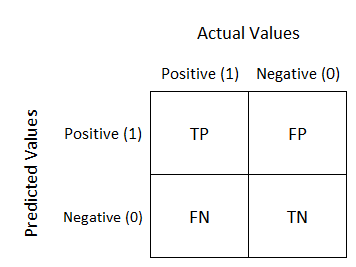

Zestawia ona rzeczywiste wartości klas z wartościami klas zamodelowanymi. W przypadku binarnym można to przedstawić w postaci TP czyli przypadki zaklasyfikowane prawidłowo do klasy prawdziwej, TN czyli przypadki zaklasyfikowane prawidłowo do klasy fałszywej, FP czyli przypadki zaklasyfikowane nieprawidłowo do klasy prawdziwej oraz FN czyli przypadki zaklasyfikowane nieprawidłowo do klasy fałszywej. 
Wartości FP są tzw. błędem I typu, czyli zaklasyfikowaniem czegoś jako prawdziwe, gdy w rzeczywistości takie nie jest. Z kolei wartości FN są błędem II typu, czyli zaklasyfikowaniem czegoś jako nieprawdziwe, gdy w rzeczywistości prawdziwe jest. 

Z takiego zestawienia najpopularniejsze są metryki:
- $Accuracy = \frac{(TP+TN)}{(TP+FP+TN+FN)}$ czyli proporcja poprawnych wyników spośród wszystkich możliwych
- $Precision = \frac{TP}{(TP+FP)}$ czyli precyzja modelu czyli ile z zaklasyfikowanych do klasy prawdziwej rzeczywiście do niej należy
- $Recall = \frac{TP}{(TP+FN)}$ czyli proporcja poprawnych wyników z klasy prawdziwej do wszystkich możliwych do uzyskania
- $F_1 = 2\cdot \frac{precision \cdot recall}{precision + recall}$ czyli średnia harmoniczna pomiędzy metrykami Precision i Recall

W naszym przypadku chcemy się skupić na minimalizacji błędu II typu kosztem błędu typu I. Wynika to z faktu, iż w przypadku popełnienia błędu I typu czyli nieprawdziwej predykcji udaru mózgu mogą zostać wykonane niepotrzebne badania oraz poniesione środki finansowe, natomiast w przypadek błędu II typu niesie poważne konsekwencje zdrowotne a w najgorszym przypadku śmierć. 

Nie wystarczy jednak minimalizacja FN, ponieważ w takim przypadku każdy kolejny pacjent byłby klasyfikowany jako osoba z udarem mózgu. Potrzebne jest pewne wyważenie między FP, a FN dlatego kierować się będziemy metrykami Precision - czyli ile osób zaklasyfikowanych z udarem rzeczywiście ma udar (wysoka wartość precyzji implikuje niską wartość FP) oraz Recall (wysoka wartość recall implikuje niską wartość FN), jak też ich średnią harmoniczną $F_1$. 

Podsumowując, dla klasy pacjentów z udarem bardziej istotna jest metryka Recall, która informuje nas jaka jest proporcja osób zaklasyfikowanych z udarem do wszystkich osób, które zaklasyfikowane być powinny. Oczekujemy wysoką wartość, gdyż oznaczać to będzie że prawidłowo wyszukujemy osoby z udarem. 

Dla pacjentów bez udaru bardziej patrzeć będziemy na metrykę Precision, która z kolei mówi nam ile zaklasyfikowanych jako osoby bez udaru rzeczywiście udaru nie mają. Wysoka wartość będzie oznaczać, że precyzyjnie wyszukujemy osoby bez udaru. 



# Modelowanie

W naszym zestawie danych występuje wiele zmiennych po wprowadzeniu polynomial features. O ile w trakcie preprocessingu danych nie usunęliśmy ich zbyt wiele i wciąż liczba zmiennych jest o wiele mniejsza od liczby obserwacji to wciąż nadmierna ich ilość prowadzić może do zjawiska overfittingu, wpływać na wyjaśnialność, czy też wprowadzać niepotrzebny szum do modelu. 

Dlatego też chcemy tą liczbę zredukować poprzez wybranie naijstotniejszych zmiennych (chociaż możliwe są inne sposoby jak redukcja wymiarowości przykładowo poprzez PCA). 

Dla każdego z modeli dokonamy inną selekcję cech, gdyż w naturalny sposób różnią się one algorytmiką działania i inne czynniki mogą wpływać na istotność zmiennych w danym modelu. 

Wytrenujemy 3 modele:

1. Regresje logistyczną jako model podstawowy z racji na łatwą interpretowalność. Dodatkowo wykorzystamy regularyzację LASSO do ograniczenia liczby cech. Ta regularyzacja dostawia dodatkowy człon w zagadnieniu minimalizacji na współczynniki występujące przy każdej z cech w metryce L1 przez co pozwala na wyzerowanie współczynników niektórych predyktorów. Tutaj także dokonamy standaryzacji zmiennych z uwagi na regularyzację LASSO, która wymaga zmienne na podobnej skali. Z kolei dla zmiennych kategorycznych zastosujemy OHE.

2. SVM czyli maszyne wektorów nośnych. Tutaj cechy wybierzemy korzystając z transformatora SFS, który wybiera cechy sekwencyjnie wstecz rozpoczynając od pełnej dostępnej puli predyktorów. Jest podobny do RFE, jednak nie wymaga aby model udostępniał informacje na temat istotności poszczególnych zmiennych a będzie to potrzebne w przypadku zastosowania innego jądra jak liniowe czyli np. jądra RBF, które z reguły posiada większą zdolność predykcyjną z racji na tworzenie nieliniowych granic decyzyjnych. Podobnie jak w przypadku regresji liniowej, dane zostanę zestandaryzowane gdyż ułatwia to znalezienie algorytmowi SVM optymalnej hiperpłaszczyzny jako granicy decyzyjnej. Z kolei dla zmiennych kategorycznych zastosujemy OHE. 

3. RandomForest czyli lasy losowe cechujące się wysoką mocą predykcji. Cechy zostaną dobrane bazując na RFE czyli rekursywnej selekecji cech. Podobnie jak przy SFS rozważane są coraz to mniejsze zbiory predyktorów ograniczane na podstawie istotności cech w modelu. Lasy losowe przy klasyfikacji nie wymagają przeskalowania danych iż podziały odbywają się ze względu na jednorodność liści przy wykorzystaniu pewnego ze współczynników (np. Giniego). Natomiast kodowanie zmiennych kategorycznych techniką OHE zwiększyłoby (w naszym przypadku drastycznie) liczbę zmiennych co jest niewskazane dla modeli drzewiastych z uwagi na tendencję do overfittingu. 


### Logistic Regression


SMOTE



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



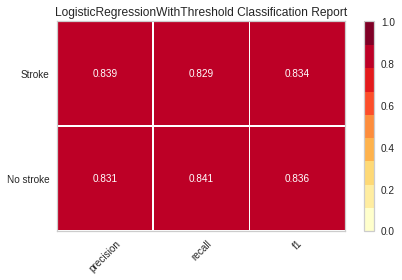

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



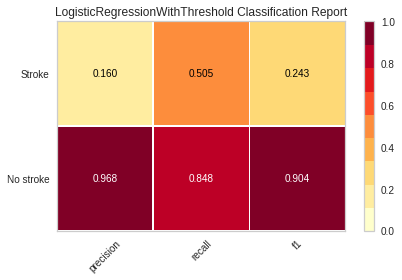


ADASYN



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



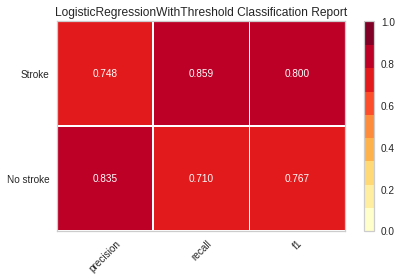

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



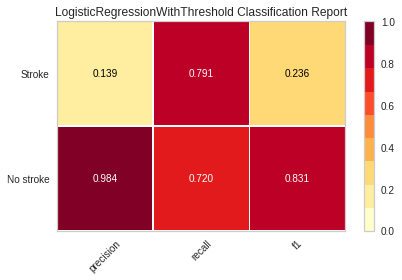


SMOTE+TOMEK



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



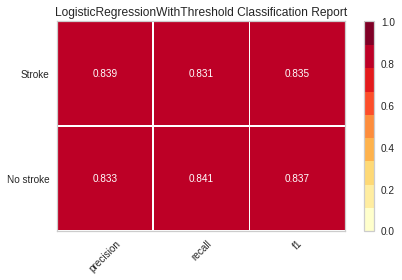

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



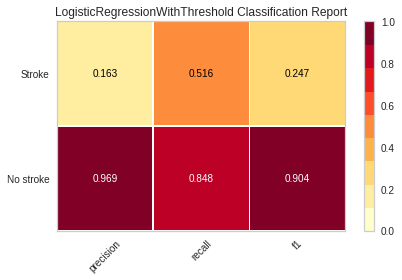


SMOTE+ENN



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



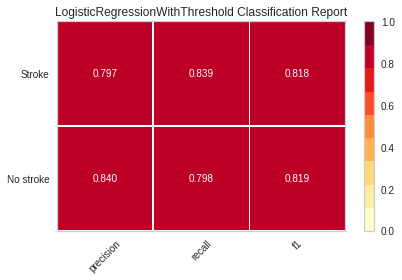

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



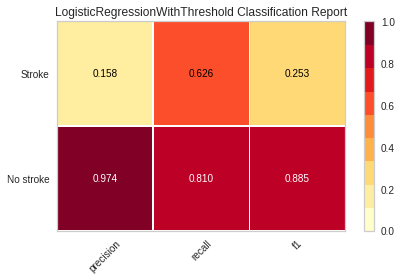

,No stroke,Stroke,accuracy,macro avg,weighted avg,metric,dataset_name,model_name
6,0.831282,0.236066,0.723606,0.533674,0.799156,f1-score,ADASYN,Base LR
2,0.904110,0.242744,0.829775,0.573427,0.868413,f1-score,SMOTE,Base LR
14,0.884629,0.252772,0.800119,0.568700,0.850525,f1-score,SMOTE+ENN,Base LR
10,0.904412,0.247368,0.830368,0.575890,0.868949,f1-score,SMOTE+TOMEK,Base LR
4,0.983719,0.138728,0.723606,0.561224,0.938111,precision,ADASYN,Base LR
0,0.967811,0.159722,0.829775,0.563767,0.924195,precision,SMOTE,Base LR
12,0.974359,0.158333,0.800119,0.566346,0.930315,precision,SMOTE+ENN,Base LR
8,0.968504,0.162630,0.830368,0.565567,0.925008,precision,SMOTE+TOMEK,Base LR
5,0.719749,0.791209,0.723606,0.755479,0.723606,recall,ADASYN,Base LR
1,0.848276,0.505495,0.829775,0.676885,0.829775,recall,SMOTE,Base LR


In [ ]:
report = pd.DataFrame()
lr_base = LogisticRegressionWithThreshold(penalty='l1', solver='saga',max_iter=10000, random_state = 123)
for X, y, name in zip([X_smote, X_ada, X_smtom, X_smenn],[y_smote, y_ada, y_smtom, y_smenn], ['SMOTE', 'ADASYN', 'SMOTE+TOMEK','SMOTE+ENN']):
  print('\n'+name +'\n')
  columns_to_standardize = list(set(list(X.filter(regex='age')) + list(X.filter(regex='log_glucose_no_outliers'))))

  results = fit_pred_score(X, y, X_test, y_test, lr_base, dataset_name = name, model_name = 'Base LR', scaler = True, ohe=True, columns_to_standardize = columns_to_standardize, cat_features = cat_features, visualize_test = True, visualize_train = True)
  
  report = pd.concat([report, results])
  report.reset_index(inplace=True, drop=True)

report.sort_values(by=['model_name','metric','dataset_name'])

In [ ]:
plot_datasets_scores = transform_report_to_plot(report[report.model_name=='Base LR'], x='dataset_name')
plotting(data = plot_datasets_scores, x='', y='value', cl='metric', type='lineplot')

0

Dla ogólnego spojrzenia spoglądamy na metrykę 'macro-avg' jako, że nie uwzględnia proporcji klas (pod kątem liczby wystąpień), a chcemy aby klasa 'Stroke' była tak samo ważna w ocenie modelu. 

Tak też dla:
- metryki $F_1$ najlepszą średnią wartość uzyskał SMOTE+TOMEK
- metryki Precision najlepszą wartość dla klasy bez udaru uzyskał ADASYN, a w uśrednieniu SMOTE+ENN
- metryki Recall najlepszą wartość dla klasy z udarem uzyskał ADASYN, a w uśrednieniu także ADASYN.

W ogólności widać, że model sprawuje się całkiem dobrze. Co prawda jest mocny spadek metryki $F_1$ oraz Precision dla klasy z udarem, ale wynika to z racji, że zbiór testowy dalej pozostaje niezbalansowany, gdzie rodzaj balansowania danych ma znaczenie i w tym przypadku lepiej radzą sobie techniki hybrydowe. Dalszą analizę modelu regresji logistycznej przeprowadzimy dla zbioru ADASYN z racji, że osiąga najlepsze wartości Precision i Recall względem klas oraz ma zbliżoną uśrednioną wartość dla wyniku $F_1$. Spróbujemy sprawdzić jeszcze różne wartości thresholdu prawdopodobieństwa $p$ oraz parametru stopnia regularyzacji C. 

In [ ]:
X = X_ada.copy()
y = y_ada.copy()
dataset_name = 'ADASYN'
columns_to_standardize = list(set(list(X.filter(regex='age')) + list(X.filter(regex='log_glucose_no_outliers'))))


Wartość p=0.1



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



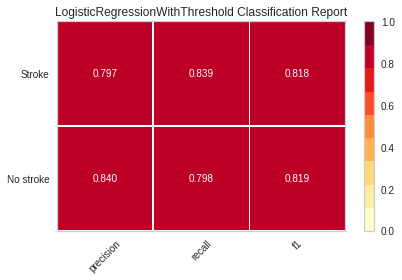

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



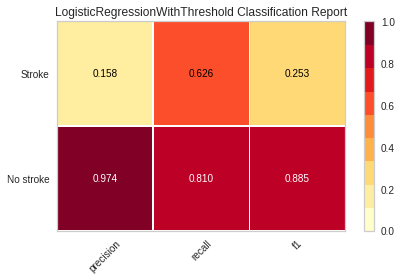


Wartość p=0.2



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



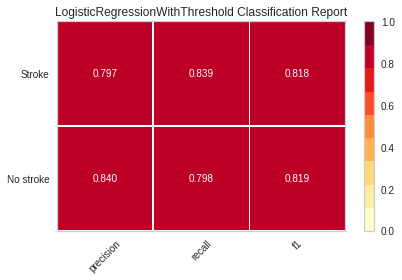

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



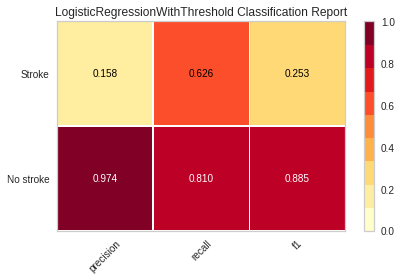


Wartość p=0.3



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



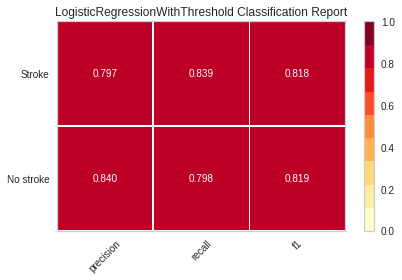

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



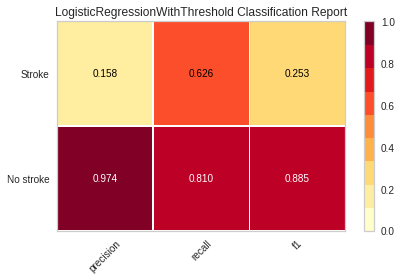


Wartość p=0.4



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



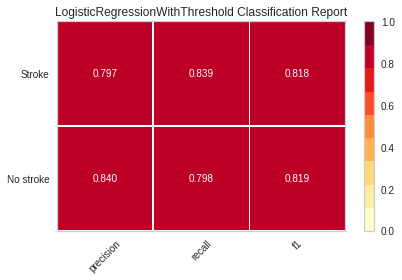

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



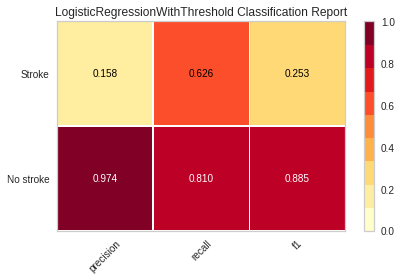


Wartość p=0.5



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



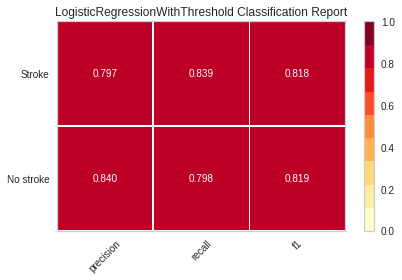

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



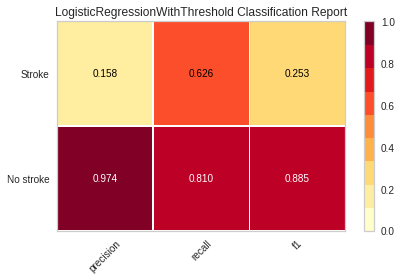


Wartość p=0.6



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



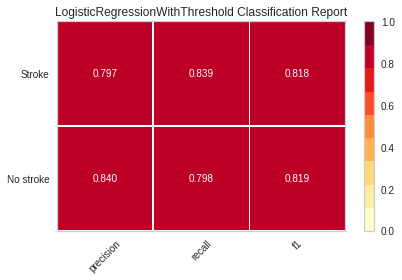

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



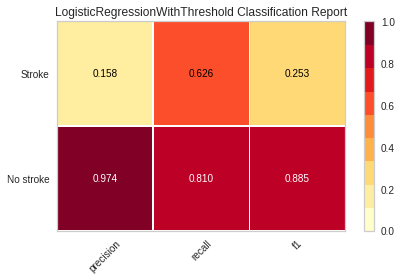


Wartość p=0.7



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



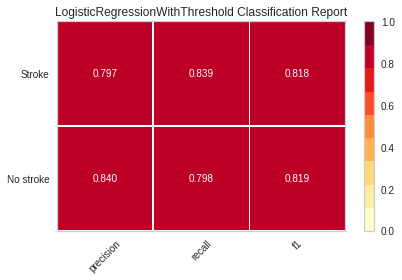

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



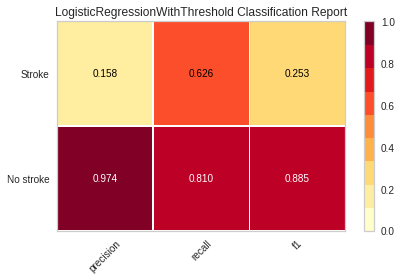


Wartość p=0.8



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



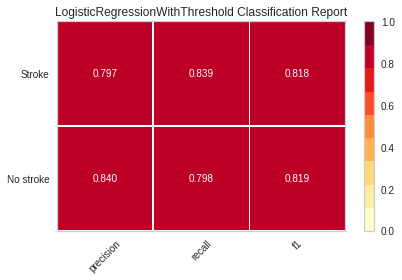

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



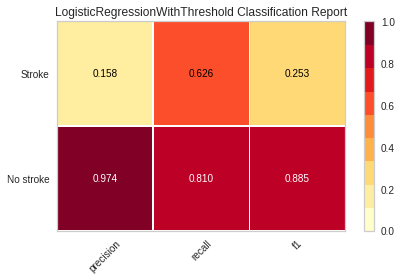


Wartość p=0.9



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



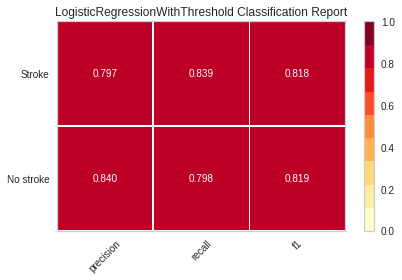

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegressionWithThreshold was fitted with feature names



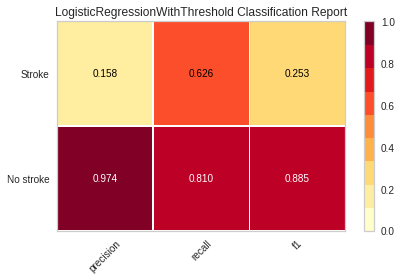

,No stroke,Stroke,accuracy,macro avg,weighted avg,metric,dataset_name,model_name
6,0.831282,0.236066,0.723606,0.533674,0.799156,f1-score,ADASYN,Base LR
2,0.904110,0.242744,0.829775,0.573427,0.868413,f1-score,SMOTE,Base LR
14,0.884629,0.252772,0.800119,0.568700,0.850525,f1-score,SMOTE+ENN,Base LR
10,0.904412,0.247368,0.830368,0.575890,0.868949,f1-score,SMOTE+TOMEK,Base LR
4,0.983719,0.138728,0.723606,0.561224,0.938111,precision,ADASYN,Base LR
0,0.967811,0.159722,0.829775,0.563767,0.924195,precision,SMOTE,Base LR
12,0.974359,0.158333,0.800119,0.566346,0.930315,precision,SMOTE+ENN,Base LR
8,0.968504,0.162630,0.830368,0.565567,0.925008,precision,SMOTE+TOMEK,Base LR
5,0.719749,0.791209,0.723606,0.755479,0.723606,recall,ADASYN,Base LR
1,0.848276,0.505495,0.829775,0.676885,0.829775,recall,SMOTE,Base LR


In [ ]:
for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
  print('\nWartość p='+str(p)+'\n')
  model_name = 'LR with p='+str(p)
  lr = LogisticRegressionWithThreshold(penalty='l1', solver='saga',max_iter=10000, random_state = 123)
  results = fit_pred_score(X, y, X_test, y_test, lr, dataset_name = dataset_name, model_name = model_name, scaler = True, ohe=True, columns_to_standardize = columns_to_standardize, cat_features = cat_features, visualize_test = True, visualize_train = True, threshold = p)
  
  report = pd.concat([report, results])
  report.reset_index(inplace=True, drop=True)

report.sort_values(by=['model_name','metric','dataset_name'])

In [72]:
plot_datasets_scores = transform_report_to_plot(report[report.model_name!='Base LR'], x='model_name')
plotting(data = plot_datasets_scores, x='', y='value', cl='metric', type='lineplot')

0

Wnioski dla:
- wartości Precision:
  -  dla klasy bez udaru jest równa prawie 1 i maleje nieznacznie ze wzrostem wartości $p$. Jest to spowodowane częstym przypisaniem osób do klasy z udarem poprzez niską wartość prawdopodobieństwa, a więc ograniczenie liczby fałszywie pozytywnych dla klasy bez udaru.
  - dla klasy z udarem jest wartość niska i rosnąca wraz ze wzrostem parametru $p$. Zbiór jest niezbalansowany i przy niskim prawdopodobieństwie często będziemy klasyfikować nieprawdziwie ludzi bez udaru jako osoby z udarem.

- wartości Recall:
  - dla klasy bez udaru znacznie rośnie wraz ze wzrostem thresholdu $p$. Wynika to faktu, że im wyższy wartość $p$ tym częściej przypisujemy osoby do klasy bez udaru i minimalizujemy tym samym wartość fałszywie negatywnych dla tej klasy.  
  - dla klasy z udarem również zaczyna się od wartości bliskiej 1 (podobnie jak Precyzja), ale maleje znacząco ze wzrostem wartości $p$. Jest to naturalna konsekwencja, że wraz ze wzrostem tego parametru maleje ilość przypisań do klasy z udarem (musi być wykazane wysokie prawdopodobieństwo przynależności), a więc wzrasta ilość pacjentów "pominiętych" przy przypisaniu do klasy z udarem.  

- wartości $F_1$:
  - jest to średnia harmoniczna obu metryk (z równą ważnością obu klas) i widać jej wzrost wraz ze wzrostem parametru. 

Jak wspomnieliśmy na początku, chcemy maksymalizować wartość Precyzji dla klasy bez udaru (0) oraz Recall dla klasy z udarem (1). Dodatkowo wysokie wartości Precyzji dla klasy (1) oraz Recall dla klasy (0) będą atutem.

W wartości $p=0.4$ możemy zaobserwować przecięcie metryk Recall dla każdej z klas. Punkt ten wydaje się być optymalny dla naszego zagadnienia, gdyż dla klasy (0) wartość precyzji i recall jest relatywnie wysoka, a dla klasy (1) następuje niewielki spadek względem Recall. Jest to też zgodne z "wyczuciem dziedzinowym" tj. chcemy być bardziej uważni na możliwość wystąpienia udaru i raczej wystarczy nam już niewielkie prawdopodobieństwo wystąpienia, aby zaklasyfikować pacjenta. Co prawda wzrasta ryzyko nieprawidziwej klasyfikacji, ale w najgorszym przypadku zostaną poniesione niepotrzebne koszty (z takiej racji nie może być to też wartość zbyt niska, gdyż prawie każdego od razu będziemy klasyfikować jako osobę z udarem). Z drugiej strony zbyt wysoka wartość wymaganego prawdopodobieństwa może narazić zdrowie, a nawet życie ludzkie (widać to chociażby po drastycznym spadku Recall dla klasy 1 co oznacza, że mocno wzrosła liczba osób zaklasyfikowanych jako bez udaru, gdzie w rzeczywistości on wystąpił). 

Ostatecznie wybierzemy wartość $p=0.4$. 

# TO DO:
1. Dostroić threshold p i parametr C dla regresji logistycznej
2. Trenowanie regresji logistycznej jako modelu baselinowego dla 4 setów i dobór odpowiedniego odcięcia $p$, jak też najlepszego zbioru.
3. Wytrenowanie kolejnych modeli w celu porównania z baselinem (regresja logistyczna) w tym
  - drzewa losowe
  - SVM
4. Jeśli starczy czasu to powtórzenie 3 dla każdego ze zbiorów zbalansowanych
5. Ostateczna prezentacja rezultatów, ROC, zestawienie, finalny wybór.

In [ ]:
transform_report_to_plot(report[report.model_name!='Base LR'], x='model_name')

,value,metric,
18,0.400117,f1-score,LR with p=0.1
22,0.462509,f1-score,LR with p=0.2
26,0.504886,f1-score,LR with p=0.3
30,0.543547,f1-score,LR with p=0.4
34,0.568700,f1-score,LR with p=0.5
38,0.584364,f1-score,LR with p=0.6
42,0.594191,f1-score,LR with p=0.7
46,0.594819,f1-score,LR with p=0.8
50,0.525388,f1-score,LR with p=0.9
17,0.967033,recall,LR with p=0.1


In [ ]:
report[report.model_name!='Base LR']

,No stroke,Stroke,accuracy,macro avg,weighted avg,metric,dataset_name,model_name
16,0.995940,0.092925,0.488731,0.544433,0.947201,precision,ADASYN,LR with p=0.1
17,0.461442,0.967033,0.488731,0.714237,0.488731,recall,ADASYN,LR with p=0.1
18,0.630677,0.169557,0.488731,0.400117,0.605788,f1-score,ADASYN,LR with p=0.1
19,1595.000000,91.000000,0.488731,1686.000000,1686.000000,support,ADASYN,LR with p=0.1
20,0.992424,0.110236,0.593713,0.551330,0.944809,precision,ADASYN,LR with p=0.2
21,0.574922,0.923077,0.593713,0.748999,0.593713,recall,ADASYN,LR with p=0.2
22,0.728067,0.196952,0.593713,0.462509,0.699400,f1-score,ADASYN,LR with p=0.2
23,1595.000000,91.000000,0.593713,1686.000000,1686.000000,support,ADASYN,LR with p=0.2
24,0.986034,0.124183,0.673191,0.555108,0.939516,precision,ADASYN,LR with p=0.3
25,0.663950,0.835165,0.673191,0.749557,0.673191,recall,ADASYN,LR with p=0.3


# Dodatkowe źródła
- http://cejsh.icm.edu.pl/cejsh/element/bwmeta1.element.desklight-002cb3e1-70f4-4321-a489-f4ced00e9d3b
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
- https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50
- https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/
- https://towardsdatascience.com/regularization-in-machine-learning-connecting-the-dots-c6e030bfaddd
- https://en.wikipedia.org/wiki/Confusion_matrix

